In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from model.traintest import get_train_test
from model.models import MasterModel
from model.utils.filtering import filter_column_or_index
from model.utils.multi_label_encoder import MultiLabelEncoder
from IPython.display import Image
import os, sys, time
train_path = os.path.join("model","data", "train.csv")
RANDOM_STATE = 123
image_display = 'static' # 'interactive'


# <a name='I'>I. Préparation des données</a>

In [2]:
# Résume l'historique en valeurs minimales/maximales/moyennes et supprime les variables avec plus de 75% de valeurs manquantes
try : 
    app = pd.read_csv(train_path, compression='gzip')
    print('app readed')
    print('forme app : ', app.shape)
    app = filter_column_or_index(app, trig_filter=75)
    app = filter_column_or_index(app, trig_filter=99.9999, axis = 1)
    print('forme app après filtrage: ', app.shape)
except :
    from model.traintest import feature_engineering_data
    feature_engineering_data()
    app = pd.read_csv(train_path, compression='gzip')
    print('app readed')
    print('forme app : ', app.shape)
    app = filter_column_or_index(app, trig_filter=75)
    app = filter_column_or_index(app, trig_filter=99.9999, axis = 1)
    print('forme app après filtrage: ', app.shape)
app.TARGET.value_counts()

app readed
forme app :  (307511, 677)
forme app après filtrage:  (202895, 384)


0.0    187384
1.0     15511
Name: TARGET, dtype: int64

In [3]:
# Vectorize via LabelEncoder les variables qualitatives
X = app[app.columns[~app.columns.isin(['SK_ID_CURR','TARGET'])]].copy()
Y = app.TARGET
qualcols = X.columns[(X.dtypes == object) | (X.columns.str.contains('^FLAG'))]
quantcols = X.columns[(X.dtypes != object) & (~X.columns.str.contains('^FLAG'))]

mle = MultiLabelEncoder()
mle.fitted= False
mle.fit(X[qualcols].astype(str))
X[qualcols] = mle.transform(X[qualcols].astype(str))

MLE - fitted ? False
MLE - fitting


In [4]:
# Séparation données train/test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, train_size=10000, random_state=RANDOM_STATE)
ytrain.value_counts()

0.0    9209
1.0     791
Name: TARGET, dtype: int64

# <a name='II'>II. Choix algorithme de re-échantillonage</a>

In [5]:
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
param_grid = {
    'prepro_type' : ['imblearn'],
    'prepro' : [
        RandomUnderSampler(sampling_strategy=1),
        NearMiss(sampling_strategy=1),
        TomekLinks(sampling_strategy='majority'),
        RandomOverSampler(sampling_strategy=1),
        SMOTE(sampling_strategy=1),
        ]
}
scoring = {
    'roc_gen' : MasterModel.score,
    'roc_test' : lambda est, x, y : MasterModel.score(est, xtest, ytest)
}
features = xtrain.columns[1:]
model = MasterModel(features=features, prepro_type='imblearn')


grid = GridSearchCV(model, param_grid=param_grid, scoring= scoring, verbose=3, refit='roc_gen', cv = 5)
grid.fit(xtrain, ytrain.ravel())
grid_res = pd.DataFrame(grid.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END prepro=RandomUnderSampler(sampling_strategy=1), prepro_type=imblearn; roc_gen: (test=0.708) roc_test: (test=0.696) total time=   3.2s
[CV 2/5] END prepro=RandomUnderSampler(sampling_strategy=1), prepro_type=imblearn; roc_gen: (test=0.655) roc_test: (test=0.690) total time=   3.2s
[CV 3/5] END prepro=RandomUnderSampler(sampling_strategy=1), prepro_type=imblearn; roc_gen: (test=0.713) roc_test: (test=0.699) total time=   3.3s
[CV 4/5] END prepro=RandomUnderSampler(sampling_strategy=1), prepro_type=imblearn; roc_gen: (test=0.710) roc_test: (test=0.703) total time=   3.2s
[CV 5/5] END prepro=RandomUnderSampler(sampling_strategy=1), prepro_type=imblearn; roc_gen: (test=0.685) roc_test: (test=0.692) total time=   3.2s
[CV 1/5] END prepro=NearMiss(sampling_strategy=1), prepro_type=imblearn; roc_gen: (test=0.540) roc_test: (test=0.540) total time=   2.8s
[CV 2/5] END prepro=NearMiss(sampling_strategy=1), prepro_type=imble

C:\Users\Julien\AppData\Local\Temp\ipykernel_23864\3243451634.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  grid_res_data.param_prepro = grid_res_data.param_prepro.astype(str).str.replace('\(.*\)', '')


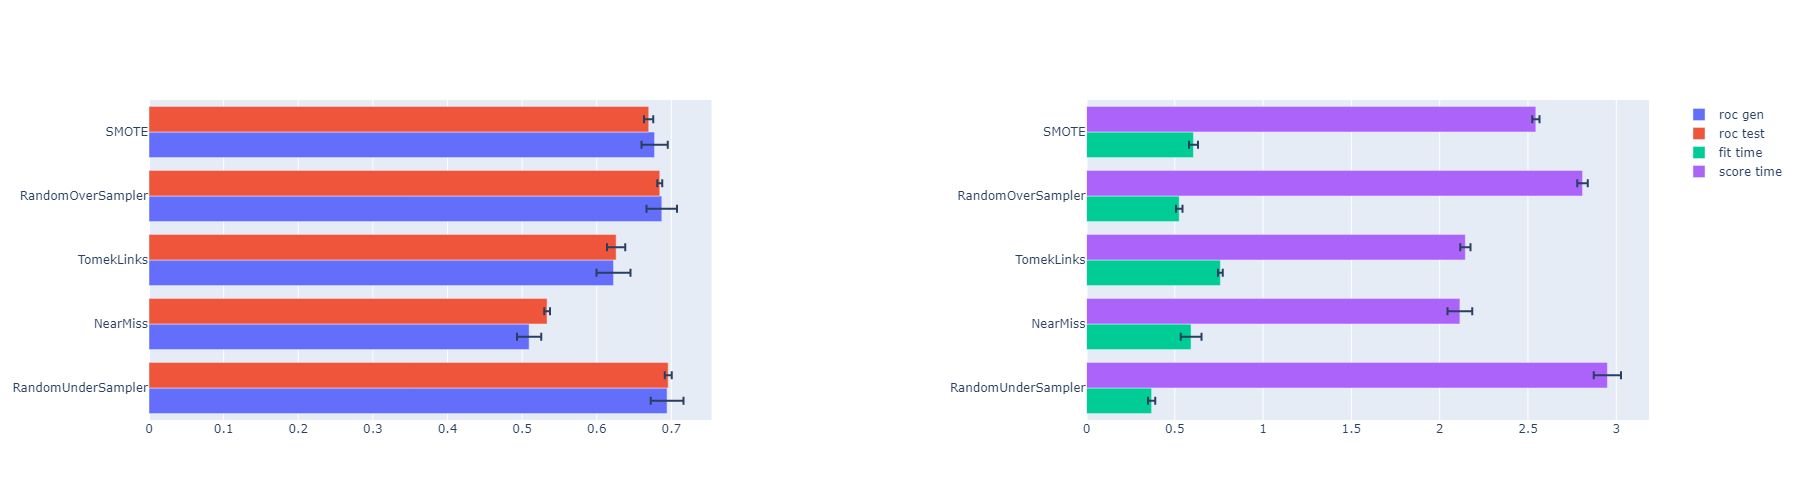

In [6]:
from plotly.subplots import make_subplots
grid_res_data = pd.DataFrame(grid.cv_results_)
grid_res_data.param_prepro = grid_res_data.param_prepro.astype(str).str.replace('\(.*\)', '')
grid_res_data = grid_res_data.set_index('param_prepro')[['mean_test_roc_gen', 'std_test_roc_gen', 'mean_test_roc_test', 'std_test_roc_test', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']]
#fig = go.Figure()

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.25)
fig.add_trace(go.Bar(
    name='roc gen',
    y=grid_res_data.index, x=grid_res_data['mean_test_roc_gen'],
    error_x=dict(type='data', array=grid_res_data['std_test_roc_gen']), orientation='h'
),row=1, col=1)

fig.add_trace(go.Bar(
    name='roc test',
    y=grid_res_data.index, x=grid_res_data['mean_test_roc_test'],
    error_x=dict(type='data', array=grid_res_data['std_test_roc_test']), orientation='h'
),row=1, col=1)

fig.add_trace(go.Bar(
    name='fit time',
    y=grid_res_data.index, x=grid_res_data['mean_fit_time'],
    error_x=dict(type='data', array=grid_res_data['std_fit_time']), orientation='h'
),row=1, col=2)

fig.add_trace(go.Bar(
    name='score time',
    y=grid_res_data.index, x=grid_res_data['mean_score_time'],
    error_x=dict(type='data', array=grid_res_data['std_score_time']), orientation='h'
),row=1, col=2)
fig.update_layout(barmode='group')
fig

if image_display == 'interactive' :
    display(fig)
else :
    img_bytes = fig.to_image(format="png", width=1800, scale=1)
    display(Image(img_bytes))

In [7]:
try :
    xtrain, xtest, ytrain, ytest = get_train_test()
except :
    from model.traintest import create_train_test
    # Permet de faire la séparation données entrainement / données test avec un resampling RandomUnderSampler.
    xtrain, xtest, ytrain, ytest = create_train_test(train_size=4000, random_state=RANDOM_STATE)
app_features = np.load('model/data/app_columns.npy', allow_pickle=True)
qualcols = np.load('model/data/qualcols.npy', allow_pickle=True)
quantcols = np.load('model/data/quantcols.npy', allow_pickle=True)
xtrain[qualcols] = mle.transform(xtrain[qualcols].astype(str))
xtest[qualcols] = mle.transform(xtest[qualcols].astype(str))

# <a name='III'>III. Choix de l'algorithme de classification</a>

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

features = xtrain.columns[1:]
rfc = MasterModel(features=features, random_state=RANDOM_STATE)

param_grid = {
    'random_state' : [RANDOM_STATE],
    'classif' : [
        RandomForestClassifier(random_state=RANDOM_STATE), 
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        DecisionTreeClassifier(random_state=RANDOM_STATE),                                
        GaussianNB(),
        KNeighborsClassifier(),
        ]
}

scoring = {
    'roc_gen' : MasterModel.score,
    'roc_test' : lambda est, x, y : MasterModel.score(est, xtest, ytest)
}

grid = GridSearchCV(rfc, param_grid=param_grid, scoring= scoring, verbose=3, refit='roc_gen', cv = 5)
grid.fit(xtrain, ytrain.TARGET.ravel())
pd.DataFrame(grid.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END classif=RandomForestClassifier(random_state=123), random_state=123; roc_gen: (test=0.718) roc_test: (test=0.718) total time=   5.8s
[CV 2/5] END classif=RandomForestClassifier(random_state=123), random_state=123; roc_gen: (test=0.693) roc_test: (test=0.719) total time=   5.3s
[CV 3/5] END classif=RandomForestClassifier(random_state=123), random_state=123; roc_gen: (test=0.675) roc_test: (test=0.721) total time=   5.3s
[CV 4/5] END classif=RandomForestClassifier(random_state=123), random_state=123; roc_gen: (test=0.714) roc_test: (test=0.721) total time=   5.3s
[CV 5/5] END classif=RandomForestClassifier(random_state=123), random_state=123; roc_gen: (test=0.733) roc_test: (test=0.722) total time=   5.4s
[CV 1/5] END classif=GradientBoostingClassifier(random_state=123), random_state=123; roc_gen: (test=0.729) roc_test: (test=0.744) total time=   9.0s
[CV 2/5] END classif=GradientBoostingClassifier(random_state=123),

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classif,param_random_state,params,split0_test_roc_gen,split1_test_roc_gen,split2_test_roc_gen,...,std_test_roc_gen,rank_test_roc_gen,split0_test_roc_test,split1_test_roc_test,split2_test_roc_test,split3_test_roc_test,split4_test_roc_test,mean_test_roc_test,std_test_roc_test,rank_test_roc_test
0,1.219096,0.024949,4.303437,0.203586,RandomForestClassifier(random_state=123),123,{'classif': RandomForestClassifier(random_stat...,0.718412,0.692754,0.674925,...,0.020458,2,0.717838,0.718933,0.720652,0.720504,0.722176,0.720021,0.001498,2
1,7.301744,0.020712,1.867060,0.053323,GradientBoostingClassifier(random_state=123),123,{'classif': GradientBoostingClassifier(random_...,0.728751,0.716765,0.717523,...,0.010530,1,0.743853,0.745013,0.744203,0.744365,0.740517,0.743590,0.001582,1
2,0.366952,0.016806,0.820428,0.025092,DecisionTreeClassifier(random_state=123),123,{'classif': DecisionTreeClassifier(random_stat...,0.588939,0.584096,0.574140,...,0.006874,3,0.582485,0.576192,0.575507,0.577600,0.580265,0.578410,0.002610,3
3,0.044899,0.002067,2.398404,0.012214,GaussianNB(),123,"{'classif': GaussianNB(), 'random_state': 123}",0.522268,0.565513,0.569350,...,0.024294,4,0.566560,0.576239,0.569744,0.577635,0.573508,0.572737,0.004098,4
4,0.028195,0.003490,3.187748,0.042379,KNeighborsClassifier(),123,"{'classif': KNeighborsClassifier(), 'random_st...",0.530104,0.542210,0.528236,...,0.014993,5,0.548675,0.549210,0.549457,0.547121,0.550385,0.548970,0.001077,5


C:\Users\Julien\AppData\Local\Temp\ipykernel_23864\1487207470.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



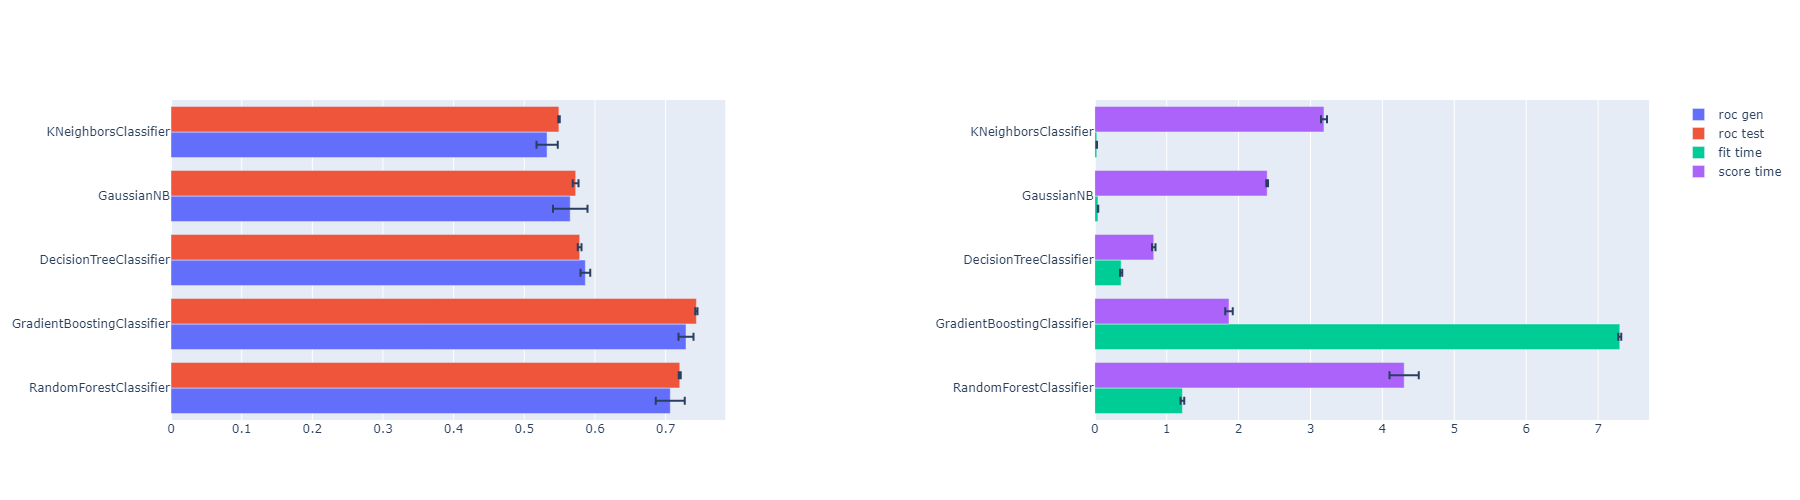

In [9]:
grid_res_data = pd.DataFrame(grid.cv_results_)
grid_res_data.param_classif = grid_res_data.param_classif.astype(str).str.replace('\(.*\)', '')
grid_res_data = grid_res_data.set_index('param_classif')[['mean_test_roc_gen', 'std_test_roc_gen', 'mean_test_roc_test', 'std_test_roc_test', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']]

from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.25)
fig.add_trace(go.Bar(
    name='roc gen',
    y=grid_res_data.index, x=grid_res_data['mean_test_roc_gen'],
    error_x=dict(type='data', array=grid_res_data['std_test_roc_gen']), orientation='h'
),row=1, col=1)

fig.add_trace(go.Bar(
    name='roc test',
    y=grid_res_data.index, x=grid_res_data['mean_test_roc_test'],
    error_x=dict(type='data', array=grid_res_data['std_test_roc_test']), orientation='h'
),row=1, col=1)

fig.add_trace(go.Bar(
    name='fit time',
    y=grid_res_data.index, x=grid_res_data['mean_fit_time'],
    error_x=dict(type='data', array=grid_res_data['std_fit_time']), orientation='h'
),row=1, col=2)

fig.add_trace(go.Bar(
    name='score time',
    y=grid_res_data.index, x=grid_res_data['mean_score_time'],
    error_x=dict(type='data', array=grid_res_data['std_score_time']), orientation='h'
),row=1, col=2)
fig.update_layout(barmode='group')
fig

if image_display == 'interactive' :
    display(fig)
else :
    img_bytes = fig.to_image(format="png", width=1800, scale=1)
    display(Image(img_bytes))

# <a name='IV'>IV. Fonctions coût métier</a>

In [10]:
bec = grid.best_estimator_
bec.save_predict(xtest, ytest)
# Calcul les valeurs de la fonction coût métier en fonction du taux d'interêt et du seuil.
exp_cost_func, optimized_triggers = bec.exploratory_cost_func(loan_rate_list=np.linspace(0,0.5,51))

# Récupère valeurs TP, TN, FP et FN
data_TF_PN = exp_cost_func[exp_cost_func.loan_rate==0].set_index('trigger')[['TP','TN']]
data_TF_PN['FP'] = 1 - data_TF_PN['TP'] 
data_TF_PN['FN'] = 1 - data_TF_PN['TN']
data_TF_PN.columns = ['Rembourse et Acc.', 'Rembourse Pas et Non Acc.', 'Rembourse et Non Acc.', 'Rembourse Pas et Acc.']
data_TF_PN = data_TF_PN.unstack().reset_index()
data_TF_PN.columns = ['type','trigger','value']
data_TF_PN

,type,trigger,value
0,Rembourse et Acc.,0.00,1.0
1,Rembourse et Acc.,0.01,1.0
2,Rembourse et Acc.,0.02,1.0
3,Rembourse et Acc.,0.03,1.0
4,Rembourse et Acc.,0.04,1.0
...,...,...,...
399,Rembourse Pas et Acc.,0.96,0.0
400,Rembourse Pas et Acc.,0.97,0.0
401,Rembourse Pas et Acc.,0.98,0.0
402,Rembourse Pas et Acc.,0.99,0.0


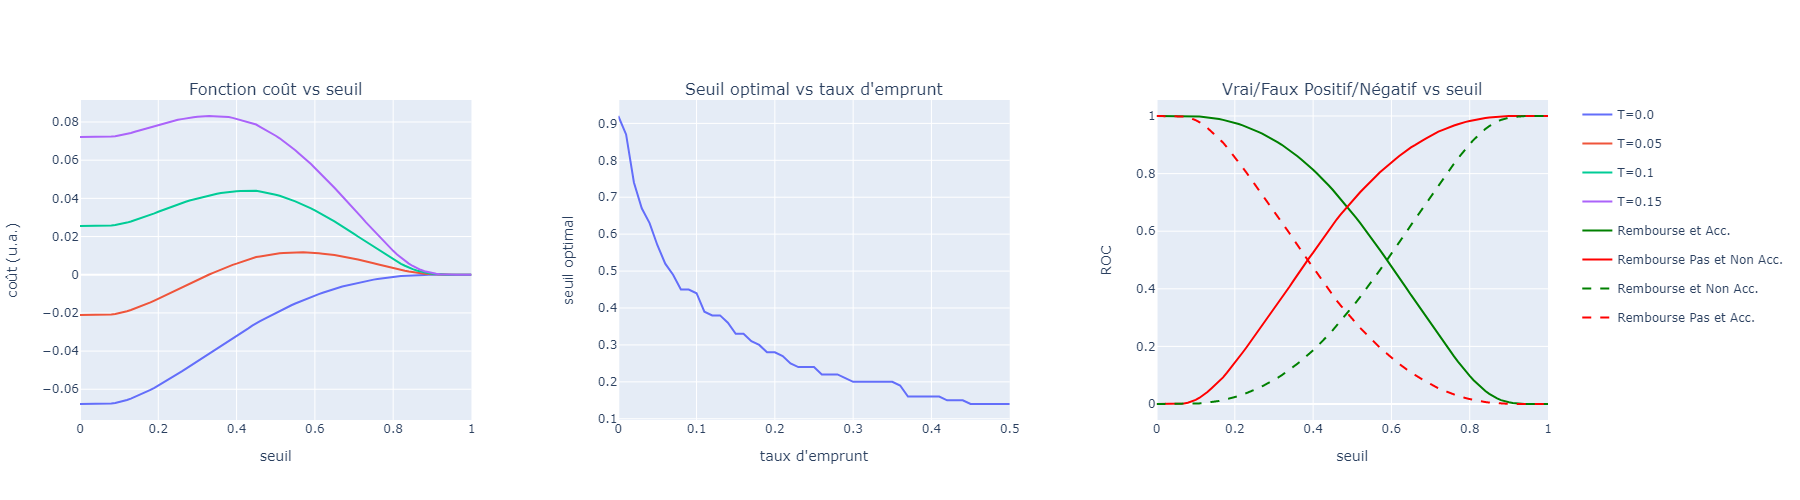

In [11]:
fig = make_subplots(rows=1, cols=3, horizontal_spacing=0.1, subplot_titles=("Fonction coût vs seuil","Seuil optimal vs taux d'emprunt", "Vrai/Faux Positif/Négatif vs seuil"))

trace1 = px.line(exp_cost_func[exp_cost_func.loan_rate.isin([0,0.05,0.10,0.15])],
    y='cost', x='trigger',
    color = 'loan_rate').data
for t in trace1 :
    t.name = ('T=%s' %(t.name))
[fig.add_trace(t, row=1, col=1) for t in trace1]
fig.update_xaxes(title_text="seuil", row=1, col=1)
fig.update_yaxes(title_text="coût (u.a.)", row=1, col=1)

trace = px.line(optimized_triggers,
    y='opt_trigger', x='loan_rate').data
fig.add_trace(trace[0], row=1, col=2)  
fig.update_xaxes(title_text="taux d'emprunt", row=1, col=2)
fig.update_yaxes(title_text="seuil optimal", row=1, col=2)


trace = px.line(data_TF_PN,
    y='value', x='trigger', color='type', color_discrete_sequence=['green', 'red','green', 'red']).data
trace[-2]['line']['dash'] = 'dash'
trace[-1]['line']['dash'] = 'dash'
[fig.add_trace(t, row=1, col=3) for t in trace]

fig.update_xaxes(title_text="seuil", row=1, col=3)
fig.update_yaxes(title_text="ROC", row=1, col=3)


fig

if image_display == 'interactive' :
    display(fig)
else :
    img_bytes = fig.to_image(format="png", width=1800, scale=1)
    display(Image(img_bytes))

# <a name='V'>V. Interprétation Globale/Locale</a>

## <a name='V.A'>V.A. Interprétation Globale</a>

In [12]:
# Calcul roc et feature_importances vs nbr de variables séléctionnées
new_features, features_list, scores = bec.explo_rfe(xtrain, ytrain.TARGET.ravel(), n_features_to_select=1, xtest=xtest, ytest=ytest, ratio_n_features=0.9 , ratio_step = 0.2, switch_coeff=1, verbose = 1)

#(  1)-> len(feat_before)= 382 ; len(feat_after)= 343 ; score=0.747 ; time=19.4
#(  2)-> len(feat_before)= 343 ; len(feat_after)= 308 ; score=0.747 ; time=18.8
#(  3)-> len(feat_before)= 308 ; len(feat_after)= 277 ; score=0.747 ; time=17.6
#(  4)-> len(feat_before)= 277 ; len(feat_after)= 249 ; score=0.747 ; time=16.7
#(  5)-> len(feat_before)= 249 ; len(feat_after)= 224 ; score=0.747 ; time=16.1
#(  6)-> len(feat_before)= 224 ; len(feat_after)= 201 ; score=0.747 ; time=15.5
#(  7)-> len(feat_before)= 201 ; len(feat_after)= 180 ; score=0.747 ; time=14.9
#(  8)-> len(feat_before)= 180 ; len(feat_after)= 162 ; score=0.746 ; time=13.9
#(  9)-> len(feat_before)= 162 ; len(feat_after)= 145 ; score=0.747 ; time=13.0
#( 10)-> len(feat_before)= 145 ; len(feat_after)= 130 ; score=0.747 ; time=12.1
#( 11)-> len(feat_before)= 130 ; len(feat_after)= 117 ; score=0.748 ; time=11.2
#( 12)-> len(feat_before)= 117 ; len(feat_after)= 105 ; score=0.747 ; time=10.3
#( 13)-> len(feat_before)= 105 ; len(fea

In [13]:
# Calcul roc et feature_importances vs nbr de variables séléctionnées pour un modèle sans les variables EXT_SOURCE_2 et 3 (scores de solvabilité)
features_wo_source = xtrain.columns[1:][~xtrain.columns[1:].isin(['EXT_SOURCE_2','EXT_SOURCE_3'])]
gbc_wo_source = MasterModel(name='GBC_wo_source', classif=GradientBoostingClassifier(random_state=RANDOM_STATE), features=features_wo_source)
gbc_wo_source.fit(xtrain, ytrain.TARGET.ravel())
display(gbc_wo_source.score(xtest, ytest))
new_features_wo_source, features_list_wo_source, scores_wo_source = gbc_wo_source.explo_rfe(xtrain, ytrain.TARGET.ravel(), n_features_to_select=1, xtest=xtest, ytest=ytest, ratio_n_features=0.9 , ratio_step = 0.2, switch_coeff=1, verbose = 1)

0.7132288789803396

#(  1)-> len(feat_before)= 380 ; len(feat_after)= 342 ; score=0.713 ; time=19.0
#(  2)-> len(feat_before)= 342 ; len(feat_after)= 307 ; score=0.713 ; time=18.1
#(  3)-> len(feat_before)= 307 ; len(feat_after)= 276 ; score=0.713 ; time=17.4
#(  4)-> len(feat_before)= 276 ; len(feat_after)= 248 ; score=0.713 ; time=16.6
#(  5)-> len(feat_before)= 248 ; len(feat_after)= 223 ; score=0.713 ; time=16.1
#(  6)-> len(feat_before)= 223 ; len(feat_after)= 200 ; score=0.713 ; time=15.6
#(  7)-> len(feat_before)= 200 ; len(feat_after)= 180 ; score=0.713 ; time=14.9
#(  8)-> len(feat_before)= 180 ; len(feat_after)= 162 ; score=0.712 ; time=14.2
#(  9)-> len(feat_before)= 162 ; len(feat_after)= 145 ; score=0.713 ; time=13.0
#( 10)-> len(feat_before)= 145 ; len(feat_after)= 130 ; score=0.713 ; time=11.8
#( 11)-> len(feat_before)= 130 ; len(feat_after)= 117 ; score=0.713 ; time=10.8
#( 12)-> len(feat_before)= 117 ; len(feat_after)= 105 ; score=0.713 ; time= 9.7
#( 13)-> len(feat_before)= 105 ; len(fea

In [14]:
# Entraine modèle avec/sans scores de solvabilité avec uniquement 16 variables.
n_features = 16
feat_w_source = features_list[n_features]
feat_wo_source = features_list_wo_source[n_features]
gbc_w_source_rfe = MasterModel(name='GBC_w_source_rfe_%d'%(n_features), classif=GradientBoostingClassifier(random_state=RANDOM_STATE), features=feat_w_source)
gbc_wo_source_rfe = MasterModel(name='GBC_wo_source_rfe_%d'%(n_features), classif=GradientBoostingClassifier(random_state=RANDOM_STATE), features=feat_wo_source)

gbc_w_source_rfe.fit(xtrain, ytrain.TARGET.ravel())
gbc_wo_source_rfe.fit(xtrain, ytrain.TARGET.ravel())

score_w_source = gbc_w_source_rfe.score(xtest, ytest)
score_wo_source = gbc_wo_source_rfe.score(xtest, ytest)

print('Score du modèle à %d variables (avec score de solvabilité) : %.3f' %(n_features, score_w_source))
print('Score du modèle à %d variables (sans score de solvabilité) : %.3f' %(n_features, score_wo_source))

fi_w_source = pd.Series(gbc_w_source_rfe.classif.feature_importances_, index=gbc_w_source_rfe.features).sort_values()
fi_wo_source = pd.Series(gbc_wo_source_rfe.classif.feature_importances_, index=gbc_wo_source_rfe.features).sort_values()


Score du modèle à 16 variables (avec score de solvabilité) : 0.735
Score du modèle à 16 variables (sans score de solvabilité) : 0.698


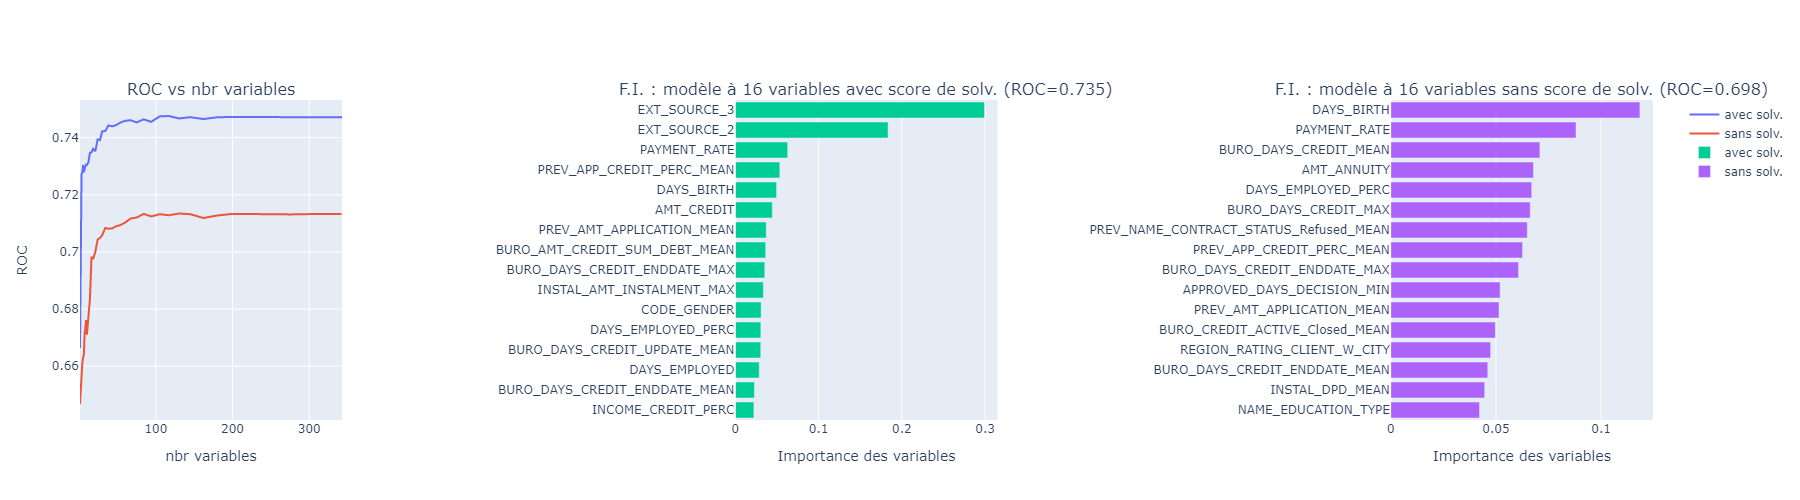

In [15]:
fig = make_subplots(
    rows=1, 
    cols=3, 
    horizontal_spacing=0.25, 
    subplot_titles=(
        "ROC vs nbr variables",
        "F.I. : modèle à 16 variables avec score de solv. (ROC=%.3f)" %(score_w_source), 
        "F.I. : modèle à 16 variables sans score de solv. (ROC=%.3f)" %(score_wo_source), 
        )
    )

score_series = pd.Series(scores).sort_index()
score_series_wo_source = pd.Series(scores_wo_source).sort_index()


fig.add_trace(go.Scatter(
    name='avec solv.',
    y=score_series, x=score_series.index,
), row=1, col=1)

fig.add_trace(go.Scatter(
    name='sans solv.',
    y=score_series_wo_source, x=score_series_wo_source.index,
), row=1, col=1)
fig.update_xaxes(title_text="nbr variables", row=1, col=1)
fig.update_yaxes(title_text="ROC", row=1, col=1)


fig.add_trace(go.Bar(
    name='avec solv.',
    x=fi_w_source, y=fi_w_source.index, orientation='h'
), row=1, col=2)
fig.update_xaxes(title_text="Importance des variables", row=1, col=2)

fig.add_trace(go.Bar(
    name='sans solv.',
    x=fi_wo_source, y=fi_wo_source.index, orientation='h', 
), row=1, col=3)
fig.update_xaxes(title_text="Importance des variables", row=1, col=3)
fig


if image_display == 'interactive' :
    display(fig)
else :
    img_bytes = fig.to_image(format="png", width=1800, scale=1)
    display(Image(img_bytes))

## <a name='V.B'>V.B. Interprétation locale</a>

In [16]:
gbc_w_source_rfe.create_shap_explainer(xtrain)
gbc_wo_source_rfe.create_shap_explainer(xtrain)

i:\Travail\OpenClassroom\Projet 7\OC-Projet7-Scorring_App\OC-Projet7-Scoring_App-API_Part\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [17]:
def predict_contrib(self, x) :
        if type(self.classif) == RandomForestClassifier : 
            prediction, bias, contributions = self.predict_contrib_many(x)
        else :
            prediction, bias, contributions = self.shap_contribs(x)
        contribs = contributions[0,:,0].tolist()
        contribs.insert(0, bias[0,0])
        contribs = np.array(contribs)
        contrib_df = pd.DataFrame(data=contribs, index=["Base"] + list(self.features), columns=["Contributions"])
        prediction = contrib_df.Contributions.sum()
        contrib_df.loc["Prediction"] = prediction
        contrib_df['values'] = x.iloc[0]
        if self.feature_importances is not None :
            df = pd.concat((contrib_df.loc[['Base']],contrib_df.loc[self.feature_importances.feature], contrib_df.loc[['Prediction']]))
            contrib_df = df

        return contrib_df

ix = 0
x = xtest.iloc[[ix]].copy()
x1 = x.copy()
x1['EXT_SOURCE_3'] = x1['EXT_SOURCE_3'] - x1['EXT_SOURCE_3']/10

x2 = x.copy()
x2['DAYS_BIRTH'] = x2['DAYS_BIRTH'] - x2['DAYS_BIRTH']/10

contribs_w_source = gbc_w_source_rfe.predict_contrib(x)
contribs_wo_source = gbc_wo_source_rfe.predict_contrib(x)

contribs_w_source1 = gbc_w_source_rfe.predict_contrib(x1)
contribs_wo_source2 = gbc_wo_source_rfe.predict_contrib(x2)

In [18]:
sorted_feat_w_score= pd.Series(gbc_w_source_rfe.classif.feature_importances_, index=gbc_w_source_rfe.features ).sort_values(ascending=True).index
sorted_feat_wo_score= pd.Series(gbc_wo_source_rfe.classif.feature_importances_, index=gbc_wo_source_rfe.features ).sort_values(ascending=True).index

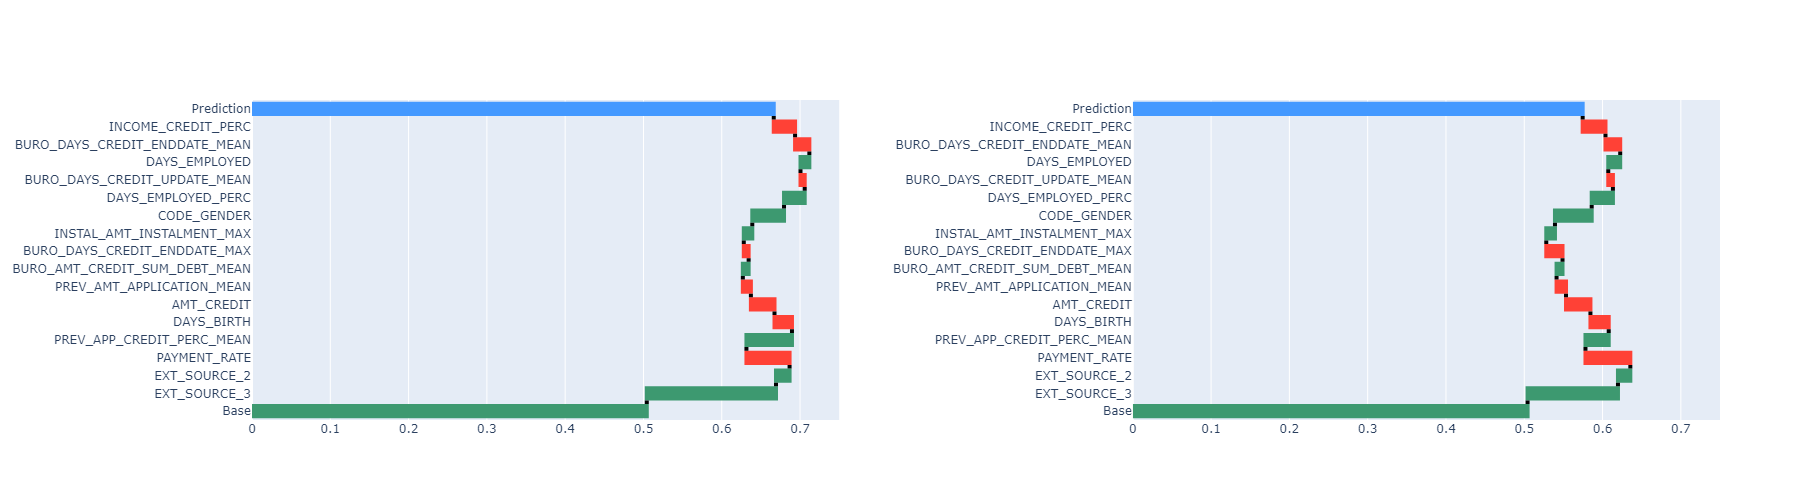

In [19]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.2, )
contribs = pd.concat((contribs_w_source.loc[['Base']],contribs_w_source.loc[sorted_feat_w_score], contribs_w_source.loc[['Prediction']]))
contribs = contribs_w_source.copy()
trace = go.Waterfall(
            name = "Prediction", #orientation = "h", 
            measure = ["relative"] * (len(contribs)-1) + ["total"],
            y = contribs.index,
            x = contribs.Contributions, orientation='h',
            connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}})
fig.add_trace(trace, row=1, col=1)

contribs = pd.concat((contribs_wo_source.loc[['Base']],contribs_wo_source.loc[sorted_feat_wo_score], contribs_wo_source.loc[['Prediction']]))
trace = go.Waterfall(
            name = "Prediction", #orientation = "h", 
            measure = ["relative"] * (len(contribs)-1) + ["total"],
            y = contribs.index,
            x = contribs.Contributions, orientation='h',
            connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}})
#fig.add_trace(trace, row=1, col=2)

contribs = pd.concat((contribs_w_source1.loc[['Base']],contribs_w_source1.loc[sorted_feat_w_score], contribs_w_source1.loc[['Prediction']]))
contribs = contribs_w_source1.copy()
trace = go.Waterfall(
            name = "Prediction", #orientation = "h", 
            measure = ["relative"] * (len(contribs)-1) + ["total"],
            y = contribs.index,
            x = contribs.Contributions, orientation='h',
            connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}})
fig.add_trace(trace, row=1, col=2)

contribs = pd.concat((contribs_wo_source2.loc[['Base']],contribs_wo_source2.loc[sorted_feat_wo_score], contribs_wo_source2.loc[['Prediction']]))
trace = go.Waterfall(
            name = "Prediction", #orientation = "h", 
            measure = ["relative"] * (len(contribs)-1) + ["total"],
            y = contribs.index,
            x = contribs.Contributions, orientation='h',
            connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}})
#fig.add_trace(trace, row=2, col=2)
fig.update_xaxes(range=[0, 0.75])
fig.update_layout(
    showlegend=False,
    #height=1000
    )


if image_display == 'interactive' :
    display(fig)
else :
    img_bytes = fig.to_image(format="png", width=1800, scale=1)
    display(Image(img_bytes))

# <a name='VI'>VI. Sauvegarde du modèle</a>

In [21]:
loan_rate_list = np.linspace(0,1,101)
bec.name = 'GBC'

#for i, m in enumerate([bec, gbc_w_source_rfe, gbc_wo_source, gbc_wo_source_rfe]):
for i, m in enumerate([gbc_w_source_rfe, gbc_wo_source_rfe]):
    print(i)
    m.save_predict(xtest, ytest)
    m.create_shap_explainer(xtrain)
    exp_cost_func, optimized_triggers = m.exploratory_cost_func(loan_rate_list = loan_rate_list, reimb_ratio_list = [0], save = True)
    if m == bec or m == gbc_w_source_rfe :
        score_solv='Oui'
    else :
        score_solv='Non'
    m.description = {
        'Classifieur' : 'GradientBoosting',
        'Nbr. Variables' : len(m.features),
        'Score Solvabilité pris en compte' : score_solv,
        #'Score ROC' : m.roc
    }
    m.save_model()
import pickle
with open(os.path.join('model','data','MLE.pkl'),'wb') as handle :
    pickle.dump(mle, handle)

0
1
2
3
